In [79]:
# imports
import ast
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# load util functions
module_path = os.getcwd()[:-9]
sys.path.insert(0, module_path)
import src.evaluation.util as util
sys.path.remove(module_path)

In [46]:
# define paths
regr_results_log_path = '../logs/regr_results/'
aggr_class_report_log_path = '../data/'

In [59]:
# load regression results table
result_file = regr_results_log_path + "regr_results.csv"
df_regr_results = pd.read_csv(result_file)

In [60]:
df_regr_results

,regressor,regressand,model,classification_task,n,group_by,delta,zscore_threshold,pearsonr,p_value,estimator,neg_rmse_train,neg_rmse_test,r2_train,r2_test,best_params
0,accuracy,false_labels_ratio,all,all,800,"{'model': False, 'classes': False, 'ratio': Fa...",False,False,-0.566728,3.683329e-69,SVR(),-2.654621,-2.490946,0.298217,0.385700,"{'C': 10.0, 'coef0': 0.8, 'degree': 3, 'gamma'..."
1,accuracy,false_labels_ratio,all,all,800,"{'model': False, 'classes': False, 'ratio': Fa...",False,False,-0.566728,3.683329e-69,SVR(),-2.581797,-2.847526,0.343331,0.197237,"{'C': 0.1, 'coef0': 0.8, 'degree': 3, 'gamma':..."


In [61]:
# --> TODO: select index of regression to use for y_true / y_pred visualization <--
index = 1

# set regression parameters based on index and regression result table
regressor = df_regr_results.iloc[index]['regressor']

cnn = df_regr_results.iloc[index]['model']
if cnn == 'all': cnn = False

classes = df_regr_results.iloc[index]['classification_task']
if classes == 'all': classes = False

use_delta = df_regr_results.iloc[index]['delta']

group_by = df_regr_results.iloc[index]['group_by']
group_by = ast.literal_eval(group_by)
use_grouping = any(group_by.values())

zscore_threshold = df_regr_results.iloc[index]['zscore_threshold']

best_params = df_regr_results.iloc[index]['best_params']
best_params = ast.literal_eval(best_params)

estimator_name = df_regr_results.iloc[index]['estimator'][:-2]

In [62]:
# load classification results table
df_class_results_raw = util.load_aggr_class_reports(aggr_class_report_log_path)

# process data based on parameters
df_regression = df_class_results_raw.query(f'metric == "{regressor}"')
df_regression = df_regression.drop(['run'], axis=1)
df_regression = df_regression.rename(columns={'value': regressor})
df_regression = util.calc_delta(df_class_results_raw, df_regression, regressor)

# filter data for set properties
df_regression = util.filter_data(
    use_grouping, group_by, df_regression, cnn, classes
)

# filter outliers if properties are set
df_regression = util.filter_outliers(
    df_regression, regressor, use_grouping, zscore_threshold
)

df_regression.reset_index(inplace=True, drop=True)
print(f'\tRegression df.shape: {df_regression.shape}')

	800 classification reports loaded - df.shape (5600, 6)
	0 rows filtered
	Regression df.shape: (800, 6)


In [76]:
# get independent and dependent variables
if use_delta:
    X_df = df_regression[[f'{regressor}_delta']]
else:
    X_df = df_regression[[regressor]]
y_df = df_regression['ratio']

# split data - random state to reproduce split in initial model selection
test_split = 0.2
if use_grouping:
    X_train, X_test, y_train, y_test = train_test_split(
                                                X_df
                                                , y_df
                                                , test_size=test_split
                                                , random_state=71
                                            )
else:
    X_train, X_test, y_train, y_test = train_test_split(
                                                X_df
                                                , y_df
                                                , test_size=test_split
                                                , random_state=71
                                                , stratify=y_df
                                            )

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    df_regression[[regressor]]
    , df_regression[regressor+'_delta']
    )

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(
    f'\tX_train.shape {X_train.shape} - y_train.shape {y_train.shape}\
    \n\tX_test.shape {X_test.shape} - y_test.shape {y_test.shape}'
)

yep = util.train_estimators({}, X_train, y_train)

estimator, temp_params = util.init_estimator('LinearRegression')

estimator.fit(X_train, y_train)
estimator.score(X_test, y_test)

# visualize estimator performance
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='True', ylabel='Predicted')
plt.show()

	X_train.shape (600, 1) - y_train.shape (600,)    
	X_test.shape (200, 1) - y_test.shape (200,)
	-0.029 (0.002) : BayesianRidge
	-0.057 (0.010) : DummyRegressor
	-0.057 (0.010) : ElasticNet
	-0.030 (0.003) : GradientBoostingRegressor
	-0.057 (0.010) : Lasso
	-0.029 (0.002) : LinearRegression
	-0.033 (0.004) : RandomForestRegressor
	-0.029 (0.002) : Ridge
	-0.029 (0.002) : SGDRegressor


0.7440196194482556

In [77]:
# scale X data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


    Regressor: accuracy
        0.84562 mean
        0.0688 std
    Regressand: False Labels Ratio
        3.325 mean
        3.18014 std

    Estimator: SVR
        -2.5818 : neg_rmse_train
        -2.84753 : neg_rmse_test
        0.34333 : r2_train
        0.19724 : r2_test



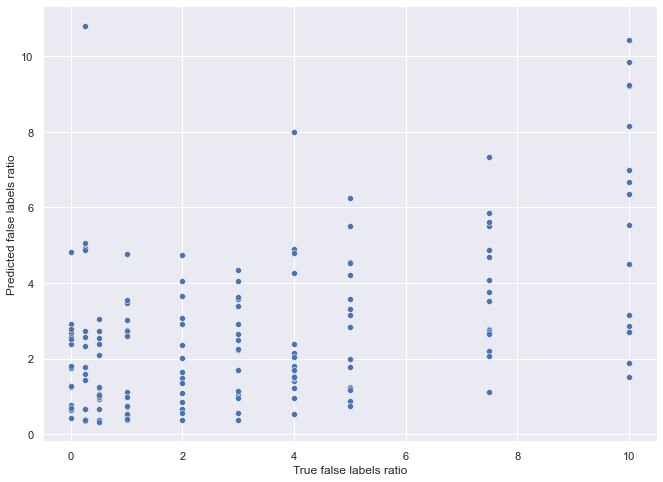

In [78]:
# init estimator, set best params
estimator, temp_params = util.init_estimator(estimator_name)
estimator.set_params(**best_params)

# train estimator
estimator.fit(X_train, y_train)
y_train_pred = estimator.predict(X_train)
y_pred = estimator.predict(X_test)

print(f'''
    Regressor: {regressor}
        {round(df_regression[regressor].mean(), 5)} mean
        {round(df_regression[regressor].std(), 5)} std
    Regressand: False Labels Ratio
        {round(df_regression['ratio'].mean(), 5)} mean
        {round(df_regression['ratio'].std(), 5)} std

    Estimator: {estimator_name}
        {round(df_regr_results.iloc[index]['neg_rmse_train'], 5)} : neg_rmse_train
        {round(df_regr_results.iloc[index]['neg_rmse_test'], 5)} : neg_rmse_test
        {round(df_regr_results.iloc[index]['r2_train'], 5)} : r2_train
        {round(df_regr_results.iloc[index]['r2_test'], 5)} : r2_test
''')

# visualize estimator performance
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='True false labels ratio', ylabel='Predicted false labels ratio')
plt.show()